In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from recycle_cnn import CNN



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
test_set = torchvision.datasets.ImageFolder('data/test',transform=trans)
test_loader = DataLoader(test_set)

model = torch.load('best_model.pt')
binary_model = torch.load('binary_best_model.pt')
model.eval()
binary_model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
num_correct = 0
all_result = []

for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    is_trash = torch.argmax(binary_model(x), 1)
    output = model(x)
    prediction = torch.argmax(output, 1)
    if is_trash[0] == 1:
        prediction[0] = 5
    
    if prediction == y:
        num_correct += 1
    
    all_result.append([y.cpu().detach().numpy()[0], prediction.cpu().detach().numpy()[0]])

accuracy = num_correct / len(test_loader)


Overall Accuracy: 0.8538283062645011
--------------------------------
cardboard Accuracy: 0.9
glass Accuracy: 0.8414634146341463
metal Accuracy: 0.8529411764705882
paper Accuracy: 0.8240740740740741
plastic Accuracy: 0.8904109589041096
trash Accuracy: 0.8


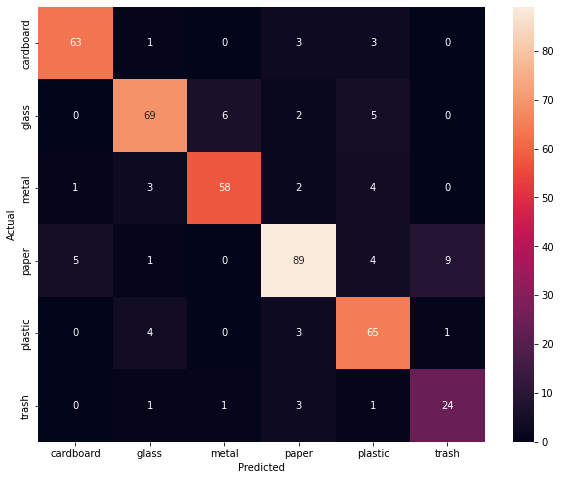

In [4]:
num_classes = len(test_set.classes)
cmt = np.zeros((num_classes, num_classes), np.int64)

for actual, predicted in all_result:
    cmt[actual, predicted] += 1

plt.figure(figsize=(10,8))
sns.heatmap(cmt, xticklabels=test_set.classes, yticklabels=test_set.classes, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print('Overall Accuracy:', accuracy)
print('--------------------------------')
for i in range(num_classes):
    per_class_acc = cmt[i, i] / cmt[i].sum()
    print(f"{test_set.classes[i]} Accuracy:", per_class_acc)
